# Another approach to do this homework:

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import math
from queue import Queue
import time
import statistics
import json
import itertools

__[RQ1]__ Build the graph G=(V, E), where V is the set of articles and E the hyperlinks among them, and provide its basic information:

In [2]:
# Creating graph from reduced set of nodes
graph=[]
G = nx.DiGraph()
for count, line in enumerate(open("wiki-topcats-reduced.txt")):
            grlst=line.replace("\n", "").split(sep="\t")
            graph.append((int(grlst[0]),int(grlst[1])))
            G.add_edge(int(grlst[0]),int(grlst[1]))

In [3]:
#Function for defining if the graph is directed or not
#basically this function check for each edge if there is reversed copy of the edge. If yes so graph is directed. 
def is_directed(graph):
    for i in graph:
        if (i[1],i[0]) in graph: return True
    return False

In [4]:
#To answer the questions for the RQ1 we use data frame.
df = pd.DataFrame(graph, columns=["A", "B"])
df.set_index("A")
print("Is Graph Directed:", is_directed(graph))     # just calling the is_directed function
print("Number of nodes:", len(set(df.A)|set(df.B))) # Number of nodes eaquals to the union of the sets 
                                                    # of initial nodes and the destination nodes 
print("Number of edges:", len(df))                  # because of that the graph is directed number of deges is number of rows in dataframe 
print("Average degree of nodes:", len(df)/len(set(df.A)|set(df.B))) # number of edges divided by the number of nodes
print("Density:", 2*len(G.edges())/(len(set(df.A)|set(df.B))*(len(set(df.A)|set(df.B))-1))) #Graph is not dense

Is Graph Directed: True
Number of nodes: 461193
Number of edges: 2645247
Average degree of nodes: 5.735661642739591
Density: 2.487320527129521e-05


__[RQ2]__ Given a category C_0 as input we want to rank all of the nodes in V according to the following criteria:

In [5]:
# filtering categories by the number of elements, by the set of nodes (counting only the nodes which are in reduced file),
# by the number of elements one more time
categoriesdata = {}
lst2=G.nodes()
with open('wiki-topcats-categories.txt') as f:
    for i, line in enumerate(f): 
        tmp = list(map(int, (line.split(';'))[1].split()))
        if len(tmp)>=3500:
            tmp=set(tmp).intersection(lst2)
            if len(tmp)>=3500:
                categoriesdata[i] =list(tmp)
f.close()

In [6]:
print('Number of correct categories:',len(categoriesdata))

Number of correct categories: 29


In [7]:
# detecting the smallest category by the number of elements in it.
INF=math.inf
minsub=[INF,INF,INF]
for i in categoriesdata:
    if len(categoriesdata[i]) < minsub[1]:
        minsub[0]=i
        minsub[1]=len(categoriesdata[i])
        minsub[2]=categoriesdata[i]
print('ID of the smallest category:',minsub[0],'\n','Number of elements:',minsub[1])

ID of the smallest category: 13996 
 Number of elements: 3720


In [8]:
# Creating weighted undirected graph based on the set of categories.
# Each node indicates one category
# An edge between two categories categories indicates that the intersection of the selected categories is not an empty set
# Each edge has a weight based on the number of computation between the intersection of two categories and the category 
# which is the smaller one in each particular pair.
lst=[]
sm=0
H=nx.Graph()
intersection={}
for i,j in itertools.combinations(categoriesdata, 2):
        intersection[(i,j)]=set(categoriesdata[i]).intersection(categoriesdata[j])
        if len(intersection[(i,j)])!=0:
            if len(categoriesdata[i])<len(categoriesdata[j]):        
                    H.add_edge(i , j, weight=(1-1/(len(intersection[(i,j)])*len(categoriesdata[i]))))
            else:  H.add_edge(i , j, weight=(1-1/(len(intersection[(i,j)])*len(categoriesdata[j]))))

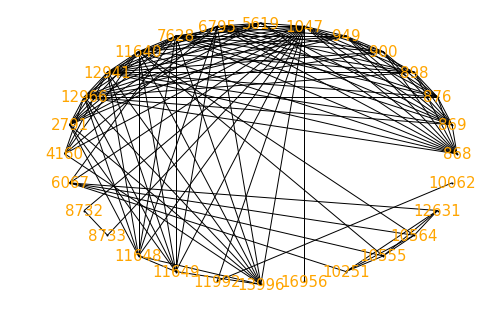

In [9]:
# ploting that graph 
nx.draw_circular(H,with_labels = True, node_color="black", node_size=1, font_color="orange", font_size=15)
plt.draw()

In [10]:
# algorithm for finding the shortest path between two nodes of the graph based on dijkstra algoritm
def dijkstra_path(G,source,target):
    previous = distance = {} # dict for distances  # dict for predcessor nodes
    unvisited = list(G.nodes()) # list of all unvisited nodes (all of the nodes for zero step of iteration)
    path = [] # list for path
    for node in unvisited:
        distance[node] = INF #initializing all the distances as an infinite number
    distance[source] = 0 # distance between source node and itself is zero
 
    while unvisited: # while there is an unvisited nodes
        minVert = None # set the node with the minimal distance 
        for v in unvisited: # for each node in the list of unvisited nodes check
            if minVert is None:
                minVert = v
            elif distance[v] < distance[minVert]:
                minVert = v # reset the node with minimal distance
        for successor, weight in G[minVert].items():
            if weight['weight'] + distance[minVert] < distance[successor]:
                distance[successor] = weight['weight'] + distance[minVert]
                previous[successor] = minVert
        unvisited.remove(minVert)
 
    currentNode = target
    while currentNode != source:
        try:
            path.insert(0,currentNode)
            currentNode = previous[currentNode]
        except KeyError:
            print('Path not reachable')
            break
    path.insert(0,source)
    if distance[target] != INF:
        return path

In [11]:
# We are going to set the category 13996 as the C_0 category because of that 
# the smallest category require the minimal number of computations to obtain the block rank.
# With the following code we compute all the pathes with minimal weigth from C_0 category to every other category using dijkstra path
path_edge={}
for i in H.nodes():
    if i!=13996:
        lst = dijkstra_path(H, i, 13996)
        if len(lst)>2:
            tmp=[]
            for j in range(0,len(lst)-1):
            # Here we should be accurate
            # We can place the smaller category to the zero position in each edge tuple because the category graph is undirected
            # It is done for the purpose of conviniency
                if len(categoriesdata[lst[j]])<len(categoriesdata[lst[j+1]]):  tmp.append((lst[j],lst[j+1]))
                else:  tmp.append((lst[j+1],lst[j]))
            if i in path_edge:  path_edge[i].append(tmp)
            else: path_edge[i]=tmp
        else:
            if len(categoriesdata[lst[0]])<len(categoriesdata[lst[1]]):  path_edge[i]=[(lst[0],lst[1])]
            else:  path_edge[i]=[(lst[1],lst[0])]

In [12]:
path_edge 
# This category consist of destination categories as keys 
# and list of edges which connect the source category C_0 with the destination category

{868: [(11640, 868), (13996, 11640)],
 869: [(12966, 869), (13996, 12966)],
 876: [(876, 12966), (13996, 12966)],
 898: [(898, 12966), (13996, 12966)],
 900: [(12966, 900), (13996, 12966)],
 949: [(949, 11640), (13996, 11640)],
 1047: [(13996, 1047)],
 5619: [(12966, 5619), (13996, 12966)],
 6795: [(13996, 6795)],
 7628: [(13996, 7628)],
 11640: [(13996, 11640)],
 12941: [(13996, 12941)],
 12966: [(13996, 12966)],
 2791: [(13996, 2791)],
 4160: [(13996, 4160)],
 6067: [(6067, 7628), (13996, 7628)],
 8732: [(8732, 1047), (13996, 1047)],
 8733: [(8733, 1047), (13996, 1047)],
 11648: [(13996, 11648)],
 11649: [(13996, 11649)],
 11992: [(11992, 1047), (13996, 1047)],
 16956: [(16956, 1047), (13996, 1047)],
 10251: [(10251, 6067), (6067, 7628), (13996, 7628)],
 10555: [(11640, 10555), (13996, 11640)],
 10564: [(11640, 10564), (13996, 11640)],
 12631: [(6067, 12631), (6067, 7628), (13996, 7628)],
 10062: [(10062, 11992), (11992, 1047), (13996, 1047)]}

In [13]:
# Creating the list of all edges which should be computed
list_path_edge=[]
for i in path_edge:
    for j in path_edge[i]:
        list_path_edge.append(j)
list_path_edge=set(list_path_edge)

In [14]:
for i in list_path_edge:
    print(i,'\t',len(categoriesdata[i[0]]),'\t',len(categoriesdata[i[1]]))

(13996, 11648) 	 3720 	 11531
(13996, 2791) 	 3720 	 5549
(8733, 1047) 	 4895 	 348300
(13996, 1047) 	 3720 	 348300
(898, 12966) 	 3737 	 5532
(13996, 11649) 	 3720 	 13865
(8732, 1047) 	 11660 	 348300
(11640, 10555) 	 4614 	 22463
(13996, 12966) 	 3720 	 5532
(11640, 10564) 	 4614 	 15159
(10251, 6067) 	 4422 	 5568
(949, 11640) 	 4588 	 4614
(13996, 4160) 	 3720 	 5192
(13996, 12941) 	 3720 	 4346
(16956, 1047) 	 4025 	 348300
(10062, 11992) 	 4760 	 7561
(11640, 868) 	 4614 	 7538
(6067, 7628) 	 5568 	 28498
(6067, 12631) 	 5568 	 10759
(12966, 869) 	 5532 	 7814
(12966, 5619) 	 5532 	 6491
(12966, 900) 	 5532 	 5827
(13996, 7628) 	 3720 	 28498
(876, 12966) 	 5097 	 5532
(13996, 11640) 	 3720 	 4614
(13996, 6795) 	 3720 	 4122
(11992, 1047) 	 7561 	 348300


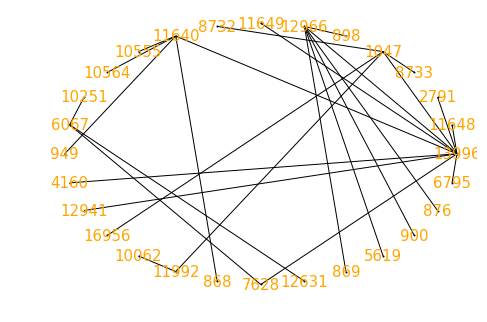

In [15]:
# Plot of the graph with optimal routes to compute the distances
GH=nx.Graph()
GH.add_edges_from(list_path_edge)
nx.draw_circular(GH,with_labels = True, node_color="black", node_size=1, font_color="orange", font_size=15)
plt.draw()

In [16]:
# Creating a dictionary of intersections for the edges in the list_path_edge
intersections={}
sumcomp=0
print('edge','\t','\t','intersection','\t','computations')
for i in list_path_edge:
    if i in intersection: intersections[i] = intersection[i]
    elif (i[1],i[0]) in intersection: intersections[i] = intersection[(i[1],i[0])]
    sumcomp+=len(intersections[i])*len(categoriesdata[i[0]]) 
    
    #computation is provided between intersection nodes of two categories with all the nodes of the smaller category.
    
    print(i,'\t',len(intersections[i]),'\t','\t',len(intersections[i])*len(categoriesdata[i[0]]))
print('Total computations',sumcomp)

edge 	 	 intersection 	 computations
(13996, 11648) 	 177 	 	 658440
(13996, 2791) 	 118 	 	 438960
(8733, 1047) 	 2 	 	 9790
(13996, 1047) 	 463 	 	 1722360
(898, 12966) 	 13 	 	 48581
(13996, 11649) 	 232 	 	 863040
(8732, 1047) 	 1 	 	 11660
(11640, 10555) 	 1 	 	 4614
(13996, 12966) 	 2 	 	 7440
(11640, 10564) 	 1 	 	 4614
(10251, 6067) 	 6 	 	 26532
(949, 11640) 	 1 	 	 4588
(13996, 4160) 	 61 	 	 226920
(13996, 12941) 	 24 	 	 89280
(16956, 1047) 	 1 	 	 4025
(10062, 11992) 	 910 	 	 4331600
(11640, 868) 	 1 	 	 4614
(6067, 7628) 	 1 	 	 5568
(6067, 12631) 	 131 	 	 729408
(12966, 869) 	 11 	 	 60852
(12966, 5619) 	 6 	 	 33192
(12966, 900) 	 26 	 	 143832
(13996, 7628) 	 4 	 	 14880
(876, 12966) 	 19 	 	 96843
(13996, 11640) 	 116 	 	 431520
(13996, 6795) 	 12 	 	 44640
(11992, 1047) 	 1 	 	 7561
Total computations 10025354


In [17]:
# Separating the input C_0 category from the other ones
for i in categoriesdata:
    if i!=13996:
        categoriesdata[i]=list(set(categoriesdata[i])-set(categoriesdata[i]).intersection(categoriesdata[13996]))

In [18]:
def BFS(graph, srcnode, destnode, predcessor, distance):
        q = Queue() 
        visited={}
        for node in G.nodes():
                visited[node] = False
                distance[node] = math.inf
                predcessor[node] = -1

        visited[srcnode] = True; 
        distance[srcnode] = 0; 
        q.put(srcnode); 

        while (q.empty()==False):
                node = q.get()
                for neinode in G.neighbors(node):
                        if visited[neinode] == False :
                                visited[neinode] = True
                                distance[neinode]= distance[node]+1
                                predcessor[neinode] = node
                                q.put(neinode)
                        if neinode == destnode: 
                                return True
        return False
    
def shortest_path_length(graph, srcnode, destnode):
        predcessor={}
        distance={} 
        if (BFS(graph, srcnode, destnode, predcessor, distance) == False):
                                raise ValueError('could not find path')
        return distance[destnode]

In [19]:
# Computing the distances between categories
distance={} # dictionary where we store edges between the categories as keys and the distance as values
for i in list_path_edge: # pick a pair of categories
    for j in intersections[i]: # for each element in itersection
            for k in categoriesdata[i[0]]: # and for each element from smaller category
                try: # compute the shortest path in both ways
                    x = shortest_path_length(G, j, k)
                # all the values of shortest path function are stored in a list
                    if i in distance:
                        distance[i].append(x)
                    else:distance[i]=[x]
                except:
                    x = -1
                try:
                    y = shortest_path_length(G, k, j)
                    if i in distance:
                        distance[i].append(y)
                    else:distance[i]=[y]
                except:
                    y = -1
    if i in distance:
        # computing the median from the list of values
        median=statistics.median(distance[i])
        if median == float(0): distance[i]=0.5
        else:distance[i]=median
    print(i, distance[i])

(13996, 11648) 4
(13996, 2791) 5.0
(8733, 1047) 7.0
(13996, 1047) 5
(898, 12966) 6
(13996, 11649) 4
(8732, 1047) 0.5
(11640, 10555) 5.0
(13996, 12966) 5
(11640, 10564) 5.0
(10251, 6067) 5.0
(949, 11640) 7
(13996, 4160) 5
(13996, 12941) 5
(16956, 1047) 6
(10062, 11992) 5.0
(11640, 868) 7.0
(6067, 7628) 4.0
(6067, 12631) 5
(12966, 869) 7.0
(12966, 5619) 6.0
(12966, 900) 7.0
(13996, 7628) 5
(876, 12966) 6
(13996, 11640) 5
(13996, 6795) 5.0
(11992, 1047) 5.0


In [22]:
# Creating a block rank based on the precomputed distances between categories.
tmp={}
blockrank={}
for i in path_edge:
    for j in path_edge[i]:
        if i in tmp: tmp[i] += distance[j]
        else: tmp[i] = distance[j]
blckrnk = sorted(tmp.items(), key=lambda kv: kv[1])
for i in blckrnk:
    blockrank[i[0]]=i[1]
blockrank

{11648: 4,
 11649: 4,
 1047: 5,
 6795: 5.0,
 7628: 5,
 11640: 5,
 12941: 5,
 12966: 5,
 2791: 5.0,
 4160: 5,
 8732: 5.5,
 6067: 9.0,
 11992: 10.0,
 10555: 10.0,
 10564: 10.0,
 876: 11,
 898: 11,
 5619: 11.0,
 16956: 11,
 868: 12.0,
 869: 12.0,
 900: 12.0,
 949: 12,
 8733: 12.0,
 10251: 14.0,
 12631: 14.0,
 10062: 15.0}

In [23]:
import json
with open('blockrank.json', 'a') as outfile:
    json.dump(blockrank, outfile)
    
blockranklist=[i for i in blockrank]
print(blockranklist)

[11648, 11649, 1047, 6795, 7628, 11640, 12941, 12966, 2791, 4160, 8732, 6067, 11992, 10555, 10564, 876, 898, 5619, 16956, 868, 869, 900, 949, 8733, 10251, 12631, 10062]


In [28]:
# For the second part of RQ2 we should clean our categories according block rank
# for this purpose we pick all the pairwise combinations of the categories with the order in blockrank list
# and remove the nodes from the category with lower ranking
disjunctcategories={}
disjunctcategories[13996]=categoriesdata[13996]
disjunctcategories[blockranklist[0]]=categoriesdata[blockranklist[0]]
for i,j in itertools.combinations(blockranklist, 2):
    disjunctcategories[j]=set(categoriesdata[j])-set(categoriesdata[j]).intersection(categoriesdata[i])

In [27]:
# Let`s see if it works
# We can see that in the input category there is not any changes. That is correct.
# There is not any changes also in the category from the position in our rank. That is correct
# Then we can observe that in some categories number of nodes after cleaning is less than the number of nodes before
for i in disjunctcategories:
    print(i,'\t', len(categoriesdata[i]),'\t', len(disjunctcategories[i]))

13996 	 3720 	 3720
11648 	 11354 	 11354
11649 	 13633 	 4819
1047 	 347837 	 338682
6795 	 4110 	 4108
7628 	 28494 	 28494
11640 	 4498 	 4309
12941 	 4322 	 4311
12966 	 5530 	 5515
2791 	 5431 	 5369
4160 	 5131 	 5131
8732 	 11660 	 11660
6067 	 5568 	 5568
11992 	 7561 	 7561
10555 	 22463 	 22463
10564 	 15159 	 4628
876 	 5097 	 5097
898 	 3737 	 3730
5619 	 6491 	 6491
16956 	 4025 	 4025
868 	 7538 	 7538
869 	 7814 	 2794
900 	 5827 	 4316
949 	 4588 	 4298
8733 	 4895 	 4895
10251 	 4422 	 4422
12631 	 10759 	 10157
10062 	 4760 	 4760


In [47]:
# In this part we are creating code which allow us to score the nodes
# The code below score the nodes based on the number of their not boundary in_edges
# Then we select all the boundary edges for each category in the order of the blockrank
# and add the score of the source edge to the score of target edge
# We can do that because the graph we are working with is the initial directed graph with 461193 nodes.

for i in blockranklist: # for each category
    for j in disjunctcategories[i]:  # for each node in that category
        pred = set(G.predecessors(j)).intersection(disjunctcategories[i]) # compute the number of in_edges from the same category
        G.nodes[j]['score'] = len(pred)                                   # set the score of the node as number of it`s in_edges 

current = disjunctcategories[13996] # set of nodes in input category is initial state of our graph
for k in disjunctcategories: # for each category
    if k!=13996:
        for j in nx.edge_boundary(G, current, disjunctcategories[k]): # for each boundary edge of the category 
                try:
                    G.nodes[j[1]]['score'] += G.nodes[j[0]]['score'] # The score of source node is added to the score of target node
                except:
                    try:
                        G.nodes[j[1]]['score'] += 0
                    except:
                        G.nodes[j[1]]['score'] = 0
        current+=disjunctcategories[k] # add the categories one by one during each iteration to the current state of the graph